In [1]:
# Import libraries

import os
import random
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img,ImageDataGenerator, array_to_img
from tensorflow.keras.applications import EfficientNetB1

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten,Dense,Conv2D,Dropout,GlobalAveragePooling2D,GlobalAvgPool2D

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
import imutils

In [3]:
# Create Directory for Training Data

os.mkdir("./contents/Crop-Brain-MRI")
os.mkdir("./contents/Crop-Brain-MRI/glioma_tumor")
os.mkdir("./contents/Crop-Brain-MRI/meningioma_tumor")
os.mkdir("./contents/Crop-Brain-MRI/pituitary_tumor")

In [4]:
# Create Directory for Testing Data

os.mkdir("./contents/Test-Brain-MRI")
os.mkdir("./contents/Test-Brain-MRI/glioma_tumor")
os.mkdir("./contents/Test-Brain-MRI/meningioma_tumor")
os.mkdir("./contents/Test-Brain-MRI/pituitary_tumor")

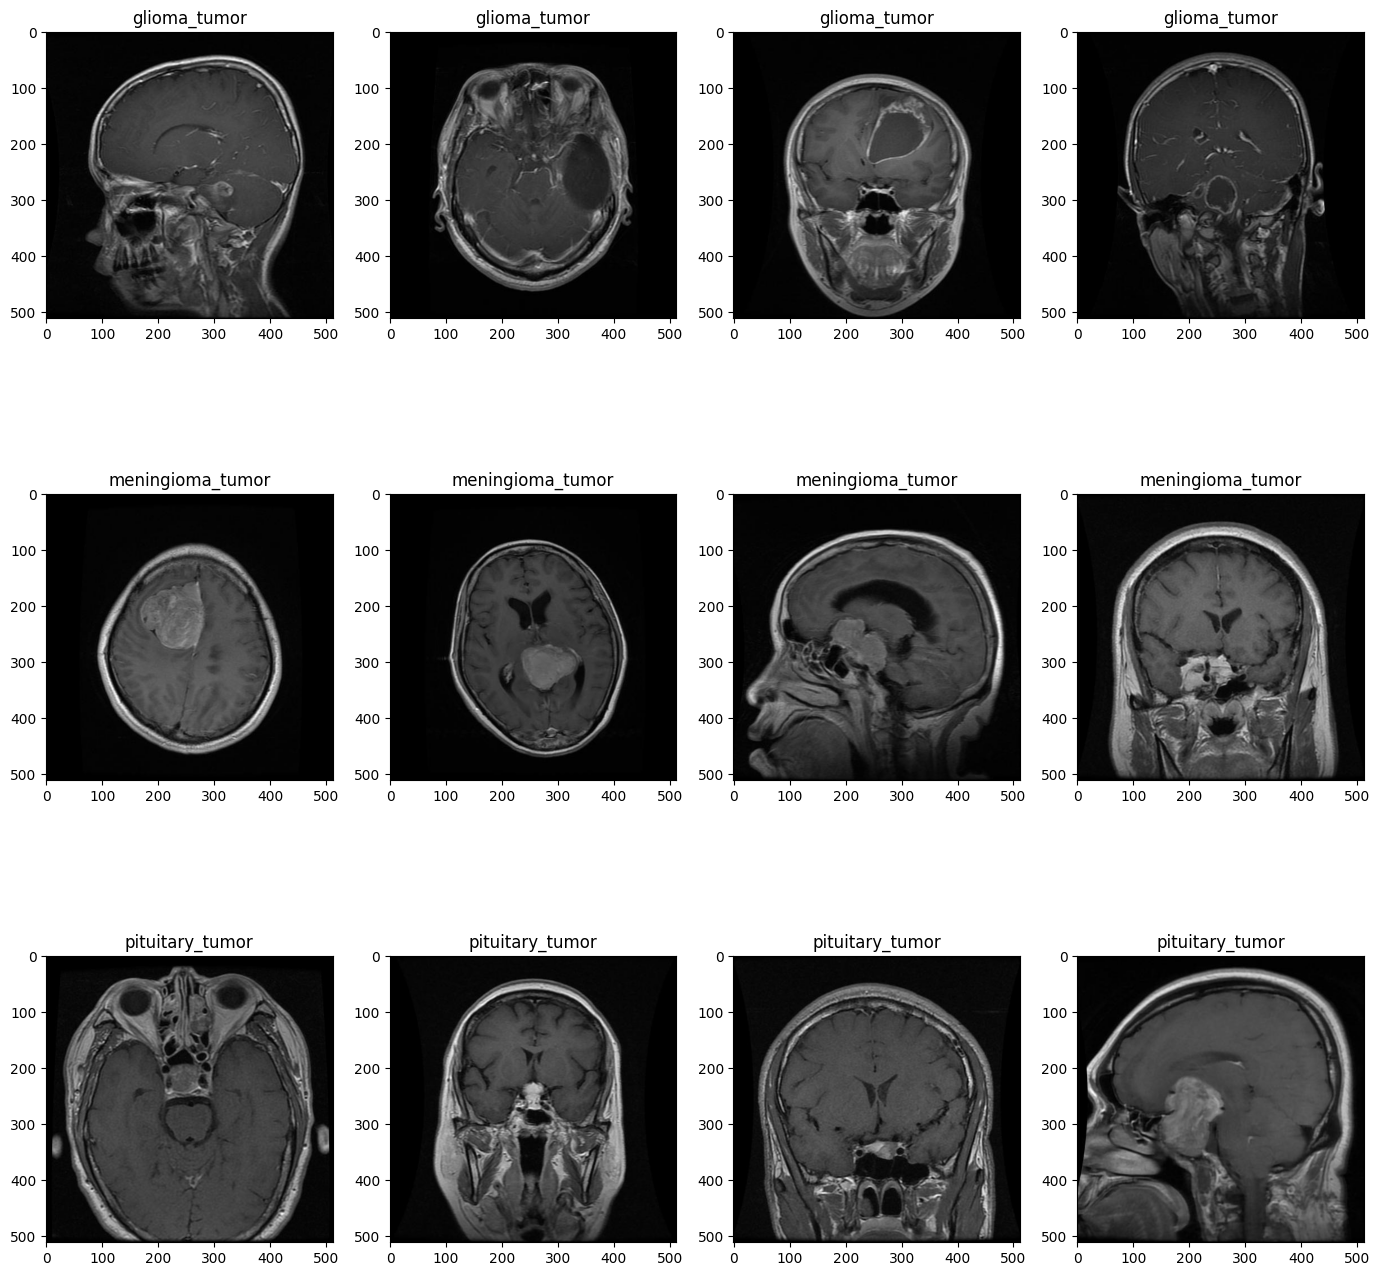

In [2]:
# Data Visualisation

train_dir = "./contents/Training/"
test_dir = "./contents/Testing/"

classes = os.listdir("./contents/Training")

files_path_dict = {}

for c in classes:
  files_path_dict[c] = list(map(lambda x :train_dir+c+'/'+x, os.listdir(train_dir+c)))

plt.figure(figsize=(17,17))
index = 0

for c in classes:
  random.shuffle(files_path_dict[c])
  path_list = files_path_dict[c][:5]

  for i in range (1,5):
    index += 1
    plt.subplot(3, 4, index)
    plt.imshow(load_img(path_list[i]))
    plt.title(c)

In [3]:
def preprocess_and_segmentation(img,plot=False):
    ogimg=img
    #     1. PreProcessing
    # **********************GrayScaling****************************
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    # ********************Filtering (Gaussian Filter) **************
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    
       
        
    #    2. Segmentation     
    # ********************Thresholding Segmentation*****************
    ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

    # ********************Watershed Segmentation********************
        
    kernel = np.ones((3,3),np.uint8)
    opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)

    # Finding sure background area
    sure_bg = cv2.dilate(thresh,kernel,iterations=3)

    # Finding sure foreground area
    dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
    ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)

    # Finding unknown region
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg,sure_fg)

    # Marker labelling
    ret, markers = cv2.connectedComponents(sure_fg)

    # Add one to all labels so that sure background is not 0, but 1
    markers = markers+1


    # Now, mark the region of unknown with zero
    markers[unknown==255] = 0
    markers = cv2.watershed(img,markers)
    img[markers == -1] = [255,0,0]

    im1 = cv2.cvtColor(img,cv2.COLOR_HSV2RGB)
    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(ogimg)
        plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(im1)
        plt.tick_params(axis='both', which='both',top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Preprocessed Image')
        plt.show()
    
    return img



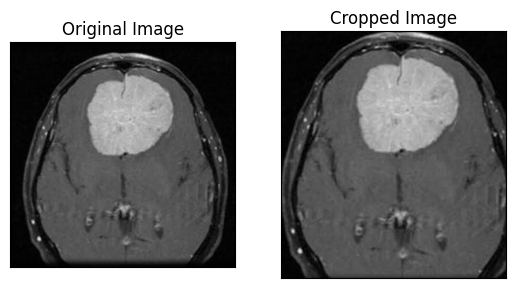

In [4]:
# Check the crop

example_img = cv2.imread("./contents/Training/meningioma_tumor/image(2).jpg")
cropped_image_example = preprocess_and_segmentation(example_img, plot=True)

In [5]:
# Crop the Training Images and Save to respective directories
glioma = train_dir + "glioma_tumor"
meningioma = train_dir + "meningioma_tumor"
pituitary = train_dir + "pituitary_tumor"

j = 0
for i in tqdm(os.listdir(glioma)):
  path = os.path.join(glioma, i)
  img = cv2.imread(path)
  img = preprocess_and_segmentation(img, plot=False)
  if img is not None:
    img = cv2.resize(img, (224, 224))
    save_path = "./contents/Crop-Brain-MRI/glioma_tumor/"+ str(j) + ".jpg"
    cv2.imwrite(save_path, img)
    j = j+1

j = 0
for i in tqdm(os.listdir(meningioma)):
  path = os.path.join(meningioma, i)
  img = cv2.imread(path)
  img = preprocess_and_segmentation(img, plot=False)
  if img is not None:
    img = cv2.resize(img, (224, 224))
    save_path = "./contents/Crop-Brain-MRI/meningioma_tumor/" +str(j) +".jpg"
    cv2.imwrite(save_path, img)
    j = j+1

j = 0
for i in tqdm(os.listdir(pituitary)):
  path = os.path.join(pituitary, i)
  img = cv2.imread(path)
  img = preprocess_and_segmentation(img, plot=False)
  if img is not None:
    img = cv2.resize(img, (224,224))
    save_path = "./contents/Crop-Brain-MRI/pituitary_tumor/"+str(j)+".jpg"
    cv2.imwrite(save_path, img)
    j = j + 1

100%|████████████████████████████████████████████████████████████████████████████████| 901/901 [00:12<00:00, 70.84it/s]


In [6]:
# Crop the Testing Images and Save to respective directories
glioma = test_dir + "glioma_tumor"
meningioma = test_dir + "meningioma_tumor"
pituitary = test_dir + "pituitary_tumor"

j = 0
for i in tqdm(os.listdir(glioma)):
  path = os.path.join(glioma, i)
  img = cv2.imread(path)
  img = preprocess_and_segmentation(img, plot=False)
  if img is not None:
    img = cv2.resize(img, (224, 224))
    save_path = "./contents/Test-Brain-MRI/glioma_tumor/"+ str(j) + ".jpg"
    cv2.imwrite(save_path, img)
    j = j+1

j = 0
for i in tqdm(os.listdir(meningioma)):
  path = os.path.join(meningioma, i)
  img = cv2.imread(path)
  img = preprocess_and_segmentation(img, plot=False)
  if img is not None:
    img = cv2.resize(img, (224, 224))
    save_path = "./contents/Test-Brain-MRI/meningioma_tumor/" +str(j) +".jpg"
    cv2.imwrite(save_path, img)
    j = j+1

j = 0
for i in tqdm(os.listdir(pituitary)):
  path = os.path.join(pituitary, i)
  img = cv2.imread(path)
  img = preprocess_and_segmentation(img, plot=False)
  if img is not None:
    img = cv2.resize(img, (224,224))
    save_path = "./contents/Test-Brain-MRI/pituitary_tumor/"+str(j)+".jpg"
    cv2.imwrite(save_path, img)
    j = j + 1

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 61.04it/s]


In [7]:
# Use Image Data Generator

datagen = ImageDataGenerator(rotation_range=10, height_shift_range=0.2, horizontal_flip=True, validation_split=0.2)
train_data = datagen.flow_from_directory('./contents/Crop-Brain-MRI/', target_size=(224,224), batch_size=32, class_mode='categorical', subset='training')

valid_data = datagen.flow_from_directory('./contents/Crop-Brain-MRI/', target_size=(224,224), batch_size=32, class_mode='categorical', subset='validation')

test_data = datagen.flow_from_directory('./contents/Test-Brain-MRI/', target_size=(224,224), class_mode='categorical')

Found 2212 images belonging to 3 classes.
Found 552 images belonging to 3 classes.
Found 15 images belonging to 3 classes.


In [8]:
# View the class dictionary

print(train_data.class_indices)
print(test_data.class_indices)

{'glioma_tumor': 0, 'meningioma_tumor': 1, 'pituitary_tumor': 2}
{'glioma_tumor': 0, 'meningioma_tumor': 1, 'pituitary_tumor': 2}


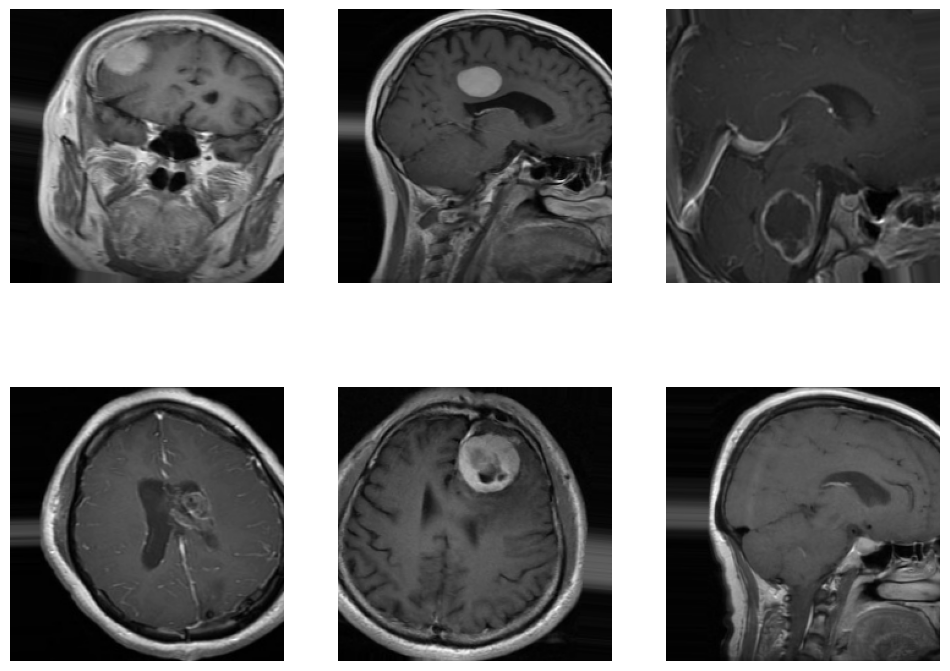

In [9]:
# View the augmented data

sample_x, sample_y =next(train_data)
plt.figure(figsize=(12,9))
for i in range (6):
  plt.subplot(2, 3, i+1)
  sample = array_to_img(sample_x[i])
  plt.axis('off')
  plt.grid(False)
  plt.imshow(sample)  
plt.show()

In [10]:
# Build the Model

cnn=tf.keras.Sequential()
cnn.add(tf.keras.layers.Conv2D(filters=64,padding='same',strides=2,kernel_size=3,activation='relu',input_shape=[224,224,3]))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2,strides=2))
cnn.add(tf.keras.layers.Flatten())
cnn.add(tf.keras.layers.Dense(3,activation='softmax'))


In [11]:
cnn.compile(optimizer=tf.keras.optimizers.Adam(),loss='categorical_crossentropy',metrics=['accuracy'])

In [12]:
elst=EarlyStopping(monitor='val_loss',patience=5,mode='min')
save_ck=ModelCheckpoint('classification_model.hdf5',save_best_only=True,monitor='val_loss',mode='min')

In [13]:
cnn.fit(train_data,validation_data=valid_data,callbacks=[save_ck],epochs=15)

Epoch 1/15
70/70 [==============================] - 65s 924ms/step - loss: 186.5652 - accuracy: 0.3612 - val_loss: 1.6689 - val_accuracy: 0.4674
Epoch 2/15
70/70 [==============================] - 49s 693ms/step - loss: 1.4295 - accuracy: 0.4521 - val_loss: 1.4060 - val_accuracy: 0.4293
Epoch 3/15
70/70 [==============================] - 48s 685ms/step - loss: 1.1198 - accuracy: 0.5090 - val_loss: 1.2092 - val_accuracy: 0.4728
Epoch 4/15
70/70 [==============================] - 48s 688ms/step - loss: 1.0611 - accuracy: 0.5172 - val_loss: 1.1225 - val_accuracy: 0.4638
Epoch 5/15
70/70 [==============================] - 46s 662ms/step - loss: 1.0375 - accuracy: 0.5181 - val_loss: 1.1773 - val_accuracy: 0.4855
Epoch 6/15
70/70 [==============================] - 45s 646ms/step - loss: 1.0151 - accuracy: 0.5443 - val_loss: 1.1697 - val_accuracy: 0.4674
Epoch 7/15
70/70 [==============================] - 45s 642ms/step - loss: 0.9962 - accuracy: 0.5344 - val_loss: 1.1827 - val_accuracy: 0.46

In [14]:
# Evaluate the model on Test Set

cnn.evaluate(test_data)

1/1 [==============================] - 0s 296ms/step - loss: 0.6262 - accuracy: 0.7333


[0.626201868057251, 0.7333333492279053]

In [19]:
import matplotlib.pyplot as plt
plt.plot(cnn.history['loss'],label='train loss')
plt.plot(cnn.history['val_loss'],label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

plt.plot(cnn.history['accuracy'],label='train acc')
plt.plot(cnn.history['val_accuracy'],label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

TypeError: 'History' object is not subscriptable